In [1]:
import numpy as np
import pandas as pd

In [ ]:
# constants
PROJECT_YEARS      = 40       
DISCOUNT_RATE      = 0.05   
DR_SENS            = [0.03, 0.04, 0.05, 0.07] 

# co2 emissions constants
ANNUAL_PASSENGERS  = 85171000 
AVG_TRIP_KM        = 2452.41  
EMISSIONS_KG_PER_PAXKM = 0.115   
RFI_MULTIPLIER     = 1.0          
SCC_USD_PER_TON    = 30      
SCC_SENS           = [14, 30, 50, 100] 

#land use and noise constants
DEFORESTED_HA      = 7650      
ES_VALUE_USD_PER_HA_YR = 2000   
AFFECTED_HOUSEHOLDS    = 300000   
NOISE_COST_USD_PER_HH  = 621    

In [ ]:
def npv_of_constant_annual(amount, r, years):
    """NPV of a constant annual amount paid at end of each year."""
    return sum(amount / ((1 + r) ** t) for t in range(1, years + 1))

def annual_aviation_co2_tonnes(pax, avg_km, kg_per_paxkm, rfi=1.0):
    """total kg = pax * km * kg/pax-km. Convert to tonnes. also includes RFI if needed"""
    kg = pax * avg_km * kg_per_paxkm
    t = (kg / 1000.0) * rfi
    return t

In [ ]:
annual_co2_tonnes = annual_aviation_co2_tonnes(
    ANNUAL_PASSENGERS, AVG_TRIP_KM, EMISSIONS_KG_PER_PAXKM, rfi=RFI_MULTIPLIER
)
annual_co2_damage_USD = annual_co2_tonnes * SCC_USD_PER_TON

annual_landuse_damage_USD = DEFORESTED_HA * ES_VALUE_USD_PER_HA_YR

annual_noise_damage_USD = AFFECTED_HOUSEHOLDS * NOISE_COST_USD_PER_HH

annual_total_USD = annual_co2_damage_USD + annual_landuse_damage_USD + annual_noise_damage_USD
central_npv_USD = npv_of_constant_annual(annual_total_USD, DISCOUNT_RATE, PROJECT_YEARS)

summary = pd.DataFrame({
    "Component": ["CO2 (aviation)", "Land-use loss", "Noise externalities", "TOTAL"],
    "Annual Damage (USD)": [
        round(annual_co2_damage_USD, 0),
        round(annual_landuse_damage_USD, 0),
        round(annual_noise_damage_USD, 0),
        round(annual_total_USD, 0)
    ]
})
summary

,Component,Annual Damage (USD)
0,CO2 (aviation),720616032.0
1,Land-use loss,15300000.0
2,Noise externalities,186300000.0
3,TOTAL,922216032.0


In [5]:
print(f"Annual CO2 (t): {annual_co2_tonnes:,.0f}")
print(f"Annual CO2 damage (USD): {annual_co2_damage_USD:,.0f}")
print(f"Annual land-use damage (USD): {annual_landuse_damage_USD:,.0f}")
print(f"Annual noise damage (USD): {annual_noise_damage_USD:,.0f}")
print(f"\nTOTAL annual environmental damages (USD): {annual_total_USD:,.0f}")
print(f"NPV over {PROJECT_YEARS} years @ {DISCOUNT_RATE*100:.1f}%: {central_npv_USD:,.0f}")

Annual CO2 (t): 24,020,534
Annual CO2 damage (USD): 720,616,032
Annual land-use damage (USD): 15,300,000
Annual noise damage (USD): 186,300,000

TOTAL annual environmental damages (USD): 922,216,032
NPV over 40 years @ 5.0%: 15,824,384,526


In [ ]:
dr_rows = []
for r in DR_SENS:
    dr_rows.append({
        "Discount Rate": r,
        "NPV (USD)": round(npv_of_constant_annual(annual_total_USD, r, PROJECT_YEARS), 0)
    })
dr_table = pd.DataFrame(dr_rows)
dr_table

scc_rows = []
for scc in SCC_SENS:
    co2_damage = annual_co2_tonnes * scc
    total = co2_damage + annual_landuse_damage_USD + annual_noise_damage_USD
    scc_rows.append({
        "SCC (USD/tCO2)": scc,
        "Annual CO2 damage (USD)": round(co2_damage, 0),
        "TOTAL annual damages (USD)": round(total, 0),
        f"NPV @ {DISCOUNT_RATE*100:.0f}% (USD)": round(npv_of_constant_annual(total, DISCOUNT_RATE, PROJECT_YEARS), 0)
    })
scc_table = pd.DataFrame(scc_rows)
scc_table

,SCC (USD/tCO2),Annual CO2 damage (USD),TOTAL annual damages (USD),NPV @ 5% (USD)
0,14,3.362875e+08,5.378875e+08,9.229658e+09
1,30,7.206160e+08,9.222160e+08,1.582438e+10
2,50,1.201027e+09,1.402627e+09,2.406779e+10
3,100,2.402053e+09,2.603653e+09,4.467631e+10


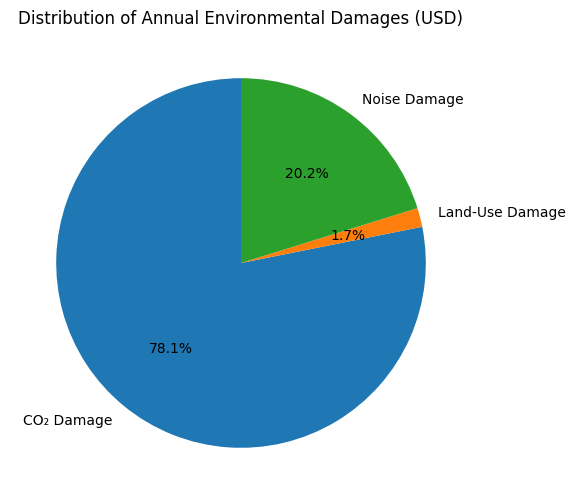

In [ ]:
import matplotlib.pyplot as plt

labels = ["CO₂ Damage", "Land-Use Damage", "Noise Damage"]
values = [720616032, 15300000, 186300000]

plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Annual Environmental Damages (USD)")
plt.show()
